<a href="https://colab.research.google.com/github/albreyes/PE-A-09/blob/main/vector_output_model_generalizado_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Pronóstico univariado a multiples pasos usando LSTM 

En este ejercicio aprenderemos a utilizar python para crear un modelo de pronóstico para una serie de datos de demanda eléctrica. El pronóstico tendrá dos o más pasos en adelanto y los resultados se presentarán paso por paso. El paso de tiempo (timestep) puede ser de una hora, un mes, un año, dependiendo del registro de tiempo de la serie.



## Preparación de los datos

Antes de pasar a la construcción del modelo se deben preparar los datos. Al igual que con el pronóstico de un paso, una serie de tiempo utilizada para el pronóstico de series de varios pasos debe dividirse en muestras con componentes de entrada y salida.

Tanto los componentes de entrada como los de salida estarán compuestos por múltiples pasos de tiempo y pueden tener o no el mismo número de pasos.

Por ejemplo, dada la serie de tiempo univariada:

\\begin{matrix}[10 & 20 & 30 & 40 & 50 & 60 & 70 & 80 & 90 ]\\\end{matrix}

Podríamos usar los últimos tres pasos de tiempo como entrada y pronosticar los dos próximos pasos de tiempo.

La primera muestra se vería de la siguiente manera:

Entrada:

\\begin{matrix}[10 & 20 & 30 ]\\\end{matrix}

Salida:


\\begin{matrix}[40 & 50 ]\\\end{matrix}

La función split_sequence() siguiente implementa este comportamiento dividiendo una serie de tiempo univariada en muestras con un número específico de pasos de tiempo de entrada y salida.

In [ ]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Podemos demostrar esta función con el conjunto de datos de ejemplo.

In [ ]:
# definimos secuancia de entrada 
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# escogemos un número de pasos de entrada y salida 
n_steps_in, n_steps_out = 3, 2
# dividimos en ejemplos X , y
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# visualizamos los resultados
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


La ejecución del ejemplo divide la serie univariada  en pasos de tiempo de entrada y salida e imprime los componentes de entrada y salida de cada uno.

Ahora que sabemos cómo preparar datos para el pronóstico de varios pasos, veamos como construir una red LSTM tipo output vector model.

Al igual que otros tipos de modelos de redes neuronales, el LSTM puede generar un vector directamente que se puede interpretar como un pronóstico de varios pasos.

Al igual que con los LSTM para datos univariados de la sección anterior, primero se deben remodelar (reshape) las muestras preparadas. El LSTM espera que los datos tengan una estructura tridimensional de la forma: [***muestras, intervalos de tiempo, características***] y, como en este caso solo tenemos una característica,  la remodelación es muy sencilla. Veamos como cambia el formato para el conjunto de entradas:

In [ ]:
print('Antes',X)
# remodela de [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print('Después',X)

Antes [[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]]
Después [[[10]
  [20]
  [30]]

 [[20]
  [30]
  [40]]

 [[30]
  [40]
  [50]]

 [[40]
  [50]
  [60]]

 [[50]
  [60]
  [70]]]


Ahora si, usemos un conjunto de datos de [demanda eléctrica en Australia](https://www.kaggle.com/dcervan/demanda-electrica-australia) con datos promedio anual durante 16 años para realizar un pronóstico a un horizonte de dos años, en pasos de un año. Utilizaremos los mismo datos de la sección anterior pero en formato anual. Primero, carguemos los datos desde drive y visualicemos:

In [ ]:
# montamos la unidad de drive en colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import csv
import numpy as np

#data_path= 'gdrive/My Drive/INEEL/cemie redes/PE-A-09/datasets/Demanda_electricidad_anual-sinFecha.csv'
#data_path= 'gdrive/My Drive/INEEL/cemie redes/PE-A-09/datasets/Demanda_electricidad_mensual-2-sinFecha.csv'
data_path= 'gdrive/My Drive/INEEL/cemie redes/PE-A-09/datasets/PerdidasTecnicas.csv'

with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    raw_seq = np.array(list(reader)).astype(float)
    raw_seq = [row[0] for row in raw_seq]

print(raw_seq)

[623.0, 1373.0, 1321.0, 1476.0, 1615.0, 1284.0, 1437.0, 1496.0, 1402.0, 14357.0, 2657.0, 2267.0, 1953.0, 2051.0, 1620.0, 970.0, 923.0, 969.0, 3115.0, 1129.0, 1177.0, 1419.0, 1345.0, 1173.0, 1146.0, 1100.0, 1492.0, 1470.0, 1562.0]


Text(0, 0.5, 'Pérdidas Técnicas')

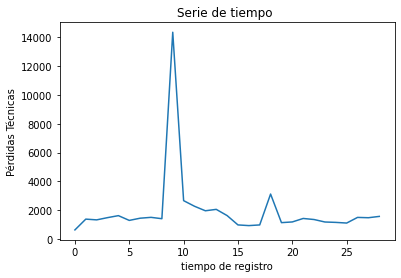

In [ ]:
import matplotlib.pyplot as plt

plt.title('Serie de tiempo ')
plt.plot(raw_seq)
plt.xlabel('tiempo de registro')
#plt.ylabel('Demanda (GW-h)')
plt.ylabel('Pérdidas Técnicas')

Con el número de pasos de entrada y salida especificados en las variables *n_steps_in* y *n_steps_out*, podemos definir un modelo de pronóstico de series de tiempo de varios pasos.

Se puede utilizar cuaquier topolgía de modelo LSTM, como Vanilla, Stacked, Bidirectional, CNN-LSTM o ConvLSTM. A continuación se define un LSTM apilado (stacked) para el pronóstico a  varios pasos.

En cada celda LSTM se define su tipo de activación, optimizador y función de pérdida (generalmente MSE) para cáculo del error.

In [ ]:

# escoger el número de pasos de timpo (time steps)
n_steps_in, n_steps_out = 6, 6
# separar en muestras (preparación)
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# remodelación del formato [muestras, timesteps] a [muestras, timesteps, características]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# definición del modelo
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1050, verbose=0)


Mostramos en forma de tabla y con una imágen información de la red LSTM construida.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6, 100)            40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 121,806
Trainable params: 121,806
Non-trainable params: 0
_________________________________________________________________


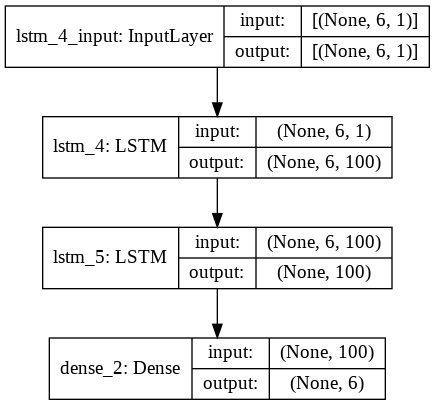

In [ ]:
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='gdrive/My Drive/INEEL/cemie redes/PE-A-09/datasets/model_plot-output-vectorPerdidasTecnicas.png', show_shapes=True, show_layer_names=True)

Y hacemos una demostracón de la predicción. Aquí seleccionamos aleatorimanente un vector de entrada, calculamos su pronóstico y lo comparamos con el vector de salida real (conocido). Para facilitar la lectura, graficamos la salida real contra la pronosticada (línea punteada verde).

secuencia de entrada: [ 623. 1373. 1321. 1476. 1615. 1284.]
secuencia de salida (predicha): [2214.796  2634.8809 4403.2783 6260.047  2188.559  1603.0776]
secuencia de salida (real): [ 1437.  1496.  1402. 14357.  2657.  2267.]


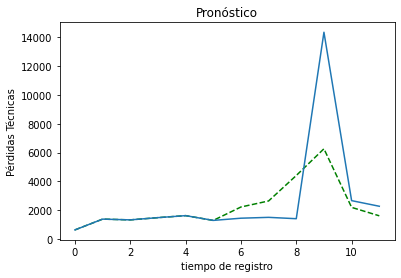

In [ ]:
# demonstrate prediction
l=X.reshape((X.shape[0],X.shape[1]))
i_sample = np.random.randint(len(y))   # Tomar un ejemplo aleatorio
x_sample = l[i_sample]
x_sample = x_sample.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_sample, verbose=0)
print('secuencia de entrada:',l[i_sample])
print('secuencia de salida (predicha):',yhat[0])
print('secuencia de salida (real):',y[i_sample])

trama_real=np.append(l[i_sample],y[i_sample])
trama_predicha=np.append(l[i_sample],yhat[0])
plt.title('Pronóstico')
plt.xlabel('tiempo de registro')
#plt.ylabel('Demanda (GW-h)')
plt.ylabel('Pérdidas Técnicas')
plt.plot(trama_predicha,color='green', linestyle='dashed')
plt.plot(trama_real)

Guardamos todos los vectores de salida pronosticados para posteriormente compararlos con los vectores de salida reales.

In [ ]:
import numpy as np

l=X.reshape((X.shape[0],X.shape[1]))

lista_tplusn=array([])
for i in l:
    i = i.reshape((1, n_steps_in, n_features))
    yhat = model.predict(i, verbose=0)
    lista_tplusn=np.append(lista_tplusn,yhat[0,:])

lista_tplusn=np.reshape(lista_tplusn, (len(l), -1))
print(lista_tplusn)

[[2214.79589844 2634.88085938 4403.27832031 6260.046875   2188.55908203
  1603.07763672]
 [3512.14672852 3849.28588867 4650.04345703 3986.53979492 1864.66125488
  1774.89050293]
 [3469.28027344 3810.94335938 4622.67919922 3951.09277344 1843.05603027
  1768.0177002 ]
 [3768.55078125 4126.97460938 4943.67822266 4227.92041016 1979.56799316
  1906.93505859]
 [2251.70532227 1588.1472168   757.40936279  710.57318115 1709.98010254
   681.99542236]
 [1634.7677002  2434.47607422 2295.7800293  1163.82165527  989.05505371
  1523.6081543 ]
 [2091.92163086 1661.59667969 1617.67053223  731.72186279 1394.26550293
  2151.39257812]
 [2230.83740234 1608.90576172  696.43554688  820.79223633 1809.25146484
  2594.55957031]
 [1556.91381836  607.94000244 1028.71533203 1862.67041016 2613.22583008
  1599.16394043]
 [1147.37060547  948.0814209  1413.89477539 3348.45141602 1241.51159668
  1403.85217285]
 [2322.16650391 1435.63757324 1858.1463623   571.92492676  996.33685303
  1244.75378418]
 [1018.7522583  1239.

Mostramos gráficamente el pronóstico del paso *t+1* al *t+n* (línea azul) vs el valor real (línea naranaja) en el paso correspondiente

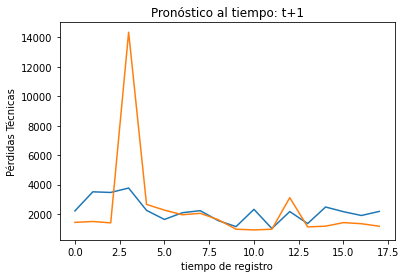

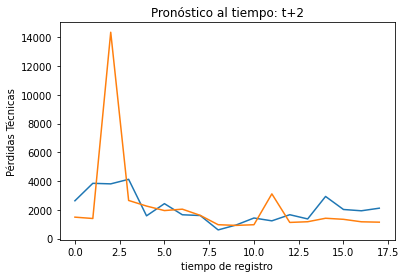

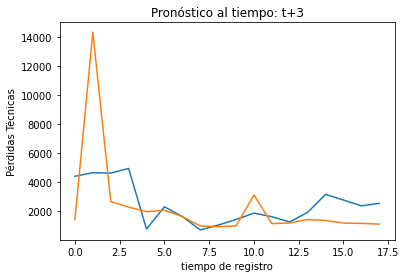

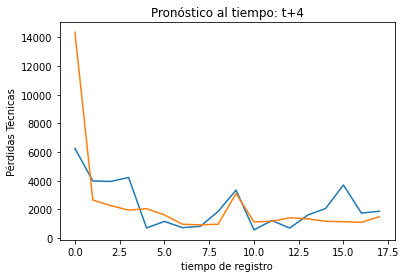

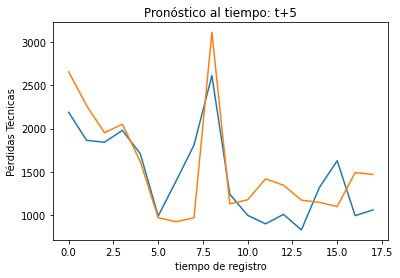

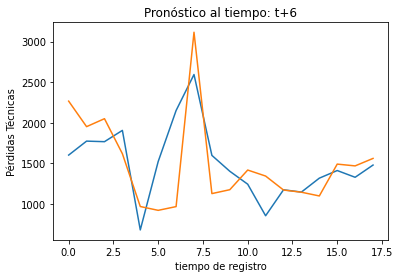

In [ ]:
for i in range(n_steps_out):
  t=i+1
  plt.title('Pronóstico al tiempo: t+%i' %t)
  plt.plot(lista_tplusn[:, i])
  plt.plot(y[:,i])
  plt.xlabel('tiempo de registro')
  #plt.ylabel('Demanda (GW-h)')
  plt.ylabel('Pérdidas Técnicas')
  plt.show()

Definimos una función simple para calcular el MAPE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Finalmente, evaluamos nuestro modelo calculando el error MAPE para cada paso del pronóstico *(t+1, t+2, ...)* que no esta nada mal.



In [ ]:
for i in range(n_steps_out):
  mape = mean_absolute_percentage_error(lista_tplusn[:, i], y[:, i])
  print(f'MAPE tiempo t+{i + 1}: {mape:.3}%')

MAPE tiempo t+1: 45.1%
MAPE tiempo t+2: 53.8%
MAPE tiempo t+3: 54.2%
MAPE tiempo t+4: 54.3%
MAPE tiempo t+5: 25.2%
MAPE tiempo t+6: 21.9%


Nota: Dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, los resultados o las diferencias en la precisión numérica pueden variar. Considere ejecutar el ejemplo varias veces y compare el resultado promedio.